# Using Python to Analyze the 2017 Thomas Fire 

## A look at impacts to land and air by the 2017 Thomas Fire in Santa Barbara County

Author: Rachel Swick

Published: December 4, 2024

More information about this anlysis, the code behind it, and data files can be found on github at the link below.

Github Link: https://github.com/rfswick/eds220-thomas-fire-analysis.git

The 2017 Thomas Fire burned 281,893 acres of Santa Barbara and Ventura county, destroyed 1,063 structures, and resulted in the deaths of 1 civilian and 1 firefighter. The fire had far reaching impacts on the surrounding communities both during and after the fire eventually burned out. This analysis shows how python can be used to visualize the burn scar caused by the fire, and demonstrate how air quality was affected before, during, and after the fire. 

## Learning Objectives

- Manipulating raster data with rioxarray
- Manipulating vector data with geopandas
- Manipluating data to create accurate and appealing visulizations with matplotlib.pyplot
- Creating an effective and efficent workflow

## About the Data

Historic California Fires GeoDatabase: This dataset includes information about all recorded wildifires within the state of California that, according to CalFire, burn "≥10 acres timber, ≥50 acres brush, ≥300 acres grass, damages or destroys three or more structures or does $300,000 worth of damage, or results in loss of life.". Accessed: November 21, 2024

Landsat Data: A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. Accessed: November 21, 2024

Air Quality Index (AQI) Data: Air quality index data from the US Environmental Protection Agency (EPA). 

## Import Libraries

You will need to begin your analysis by loading relevant pythong packages.

In [1]:
# Load libraries
import os 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rioxarray as rioxr

## Load Data

### Thomas Fire Boundary

The perimeter of the Thomas Fire was aquired by filtering the Historic California Fires GeoDatabase by year (2017) and fire name (Thomas). This code can be found at the github repository link above. 

In [2]:
# Load Thomas Fire boundary data
thomas_fire = gpd.read_file(os.path.join('data', 'thomas_fire.shp'))

### Landsat Data



In [3]:
# Load landsat data
landsat = rioxr.open_rasterio(os.path.join('data', 'landsat8-2018-01-26-sb-simplified.nc'))

In [4]:
# Display landsat contents
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

The landsat data has three dimensions (x, y, band), and five variables (red, green, blue, nir08, swir22). The band dimension contains no information and is making the dataset needlessly three dimensional.

In [5]:
# Remove band dimension
# Remove coordinates associated to band
landsat = landsat.squeeze()
landsat = landsat.drop_vars('band')
print(landsat.dims, landsat.coords)

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0


## True Color Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


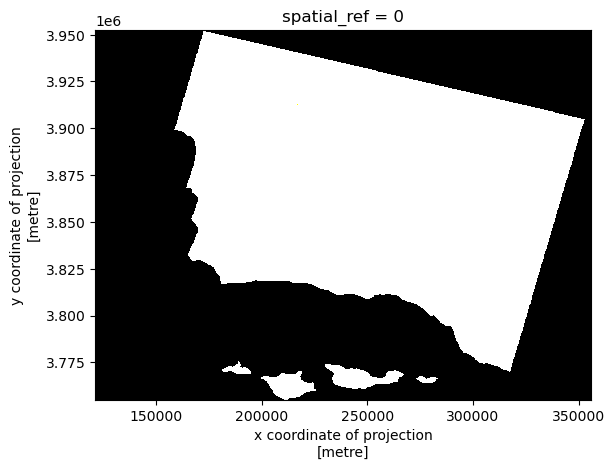

In [6]:
# Create a true color (RGB) image of Santa Barbara County
# Select the "red", "green", and "blue" variables
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

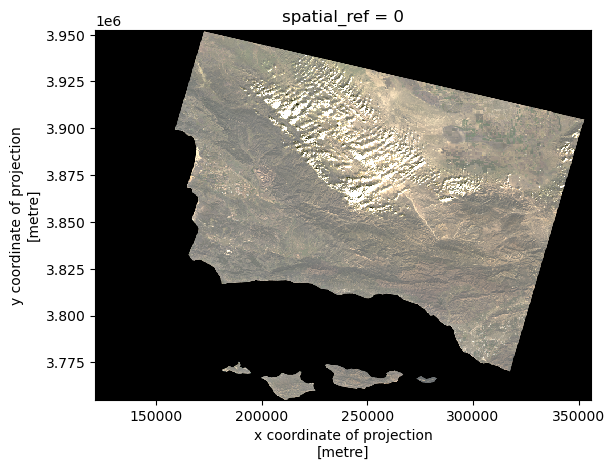

In [7]:
# Create a true color (RGB) image of Santa Barbara County
# Set the `robust` parameter to `True`
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

The cloud RGB values are outliers compared to the values of the rest of the image. This causes the rest of the values to be squished when plotting which results in not being able to see anything in the resulting image. The robust parameter pulls weight away from these outliers, allowing the rest of the image to scale properly.

## False Color Image

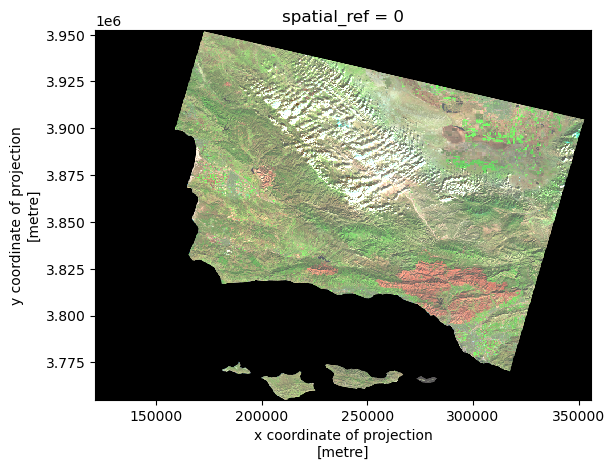

In [8]:
# Create a false color image of Santa Barbara County
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

## False Color Map of the 2017 Thomas Fire

In [9]:
# Confirm the CRS of the data match
if thomas_fire.crs == landsat.rio.crs:
    print("The CRS match.")
else:
    thomas_fire = thomas_fire.to_crs(landsat.rio.crs)
    print("The CRS match.")

The CRS match.


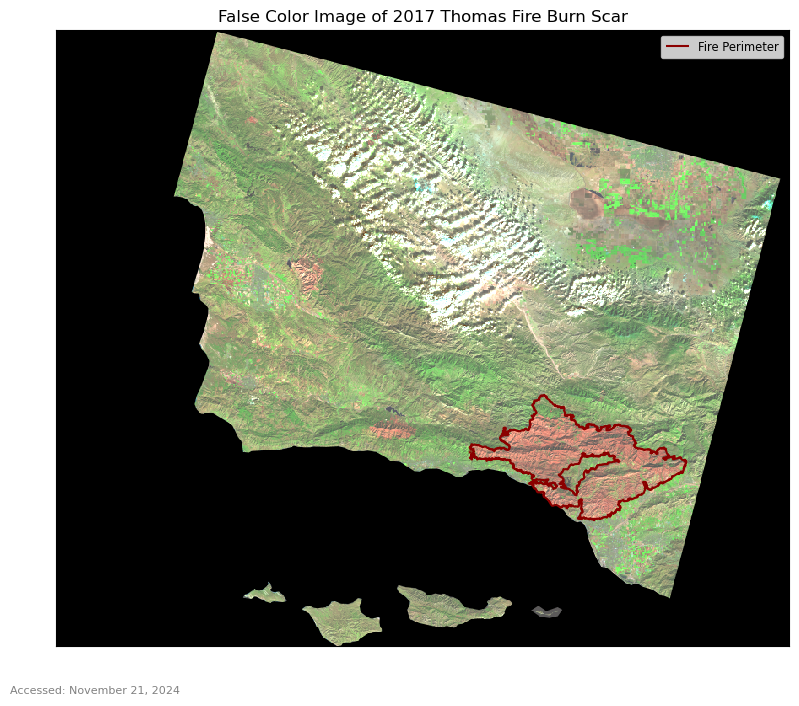

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  

# Add landsat data
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax,
                                                           robust=True)

# Add Thomas Fire Perimeter
thomas_fire.geometry.boundary.plot(ax=ax,
                                   color='darkred',
                                   linewidth=1.5,
                                   label="Fire Perimeter")

# Add legend
ax.legend(fontsize='small')

# Add title
ax.set_title("False Color Image of 2017 Thomas Fire Burn Scar")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

# Add access date
plt.figtext(0.1, 0.05, 
            "Accessed: November 21, 2024", 
            fontsize=8, 
            color="grey")

plt.show()

## Visualizing AQI during the 2017 Thomas Fire in Santa Barbara County

In [11]:
# Read in data
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.csv', 
                     index_col=['Date'],   # Set the index to be the `Date` column
                     parse_dates=['Date']) # Update the `Date` column to a `pandas.datetime` object
aqi_18 = pd.read_csv('data/daily_aqi_by_county_2018.csv',
                     index_col=['Date'],   
                     parse_dates=['Date'])

In [12]:
# Combine the `aqi_17` and `aqi_18` dataframes into a single dataframe
aqi = pd.concat([aqi_17, aqi_18])
       
# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
              )

In [13]:
# Select data only from Santa Barbara County
aqi_sb = (aqi[aqi['county_name'] == 'Santa Barbara']
          # Remove the `state_name`, `county_name`, `state_code`, and `county_code` columns
          .drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])
         )

In [14]:
# Calculate AQI rolling average over 5 days and add to a new column
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()

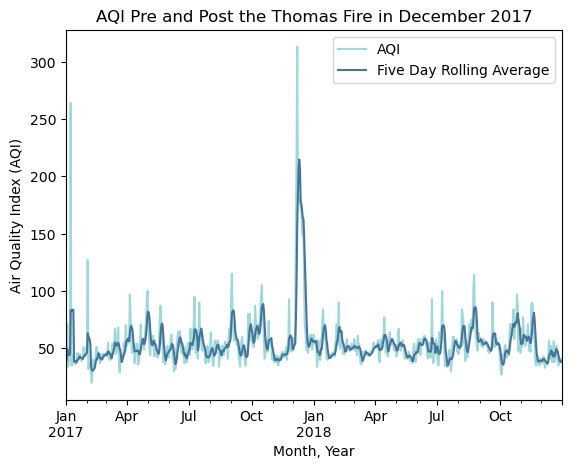

In [15]:
# Line plot 
(aqi_sb.plot(y=['aqi', 'five_day_average'],
            title ='AQI Pre and Post the Thomas Fire in December 2017',
            xlabel='Month, Year',
            ylabel='Air Quality Index (AQI)',        
            color = {'aqi':'#9ED8DB',
                     'five_day_average': '#467599'
                    }
           ).legend(['AQI','Five Day Rolling Average'])
)